In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!pip install open3d 1>/dev/null
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import sys
import os
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

from tqdm import tqdm
import json

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from models_adl4cv.patching import get_nearest_neighbors_batch_pytorch3d, generate_non_overlapping_patches, get_nearest_neighbors_batch_pytorch3d_indicies

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [ ]:
import torch
import numpy as np
from pytorch3d.ops import knn_points
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import random
import logging

In [ ]:
# !git pull

In [ ]:
NPOINTS = 2048 * 3
CATEGORY = "chair"
BATCH_SIZE = 8 * 3 # 4
PATCH_SIZE = 512

In [ ]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
tr_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='train',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)6144 (test)5000


In [ ]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset,
                                               batch_size=BATCH_SIZE,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

In [ ]:
print(tr_dataset[1]['train_points'].shape)

torch.Size([6144, 3])


In [ ]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size())
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,idx,:]

def remove_random_knn_points(patched_input, points_to_remove):
    B, N, C = patched_input.shape
    assert points_to_remove <= N

    result, idx = get_nearest_neighbors_batch_pytorch3d_indicies(patched_input, points_to_remove)

    mask = torch.ones((patched_input.shape[0], patched_input.shape[1]), dtype=torch.bool)
    for i in range(idx.shape[0]):
        mask[i, idx[i]] = False  # Set to False for indices to remove

    filtered_data = patched_input[mask.unsqueeze(-1).repeat(1, 1, patched_input.shape[-1])].view(B, N - points_to_remove, C)

    return filtered_data

## Training

In [ ]:
import itertools

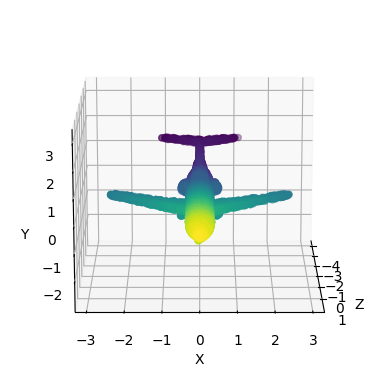

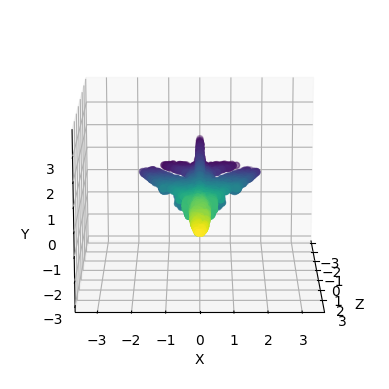

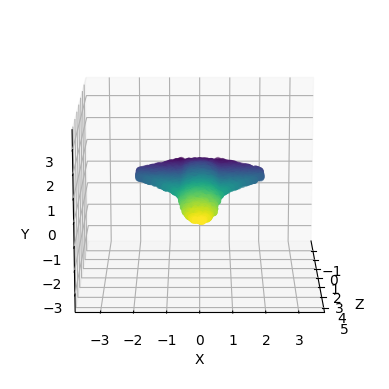

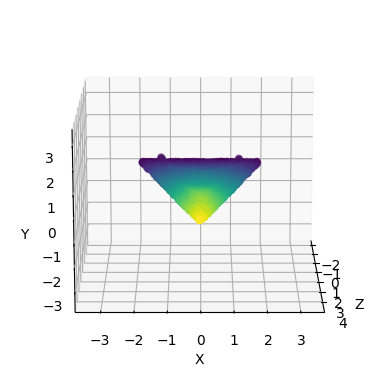

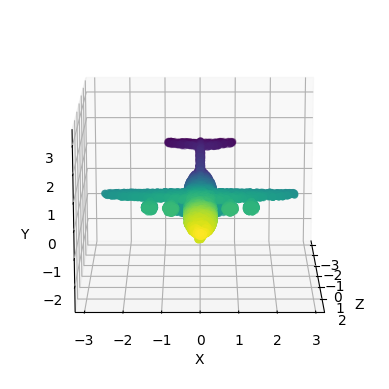

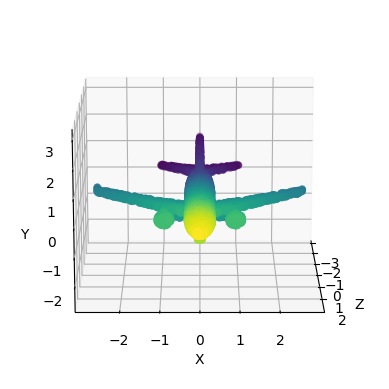

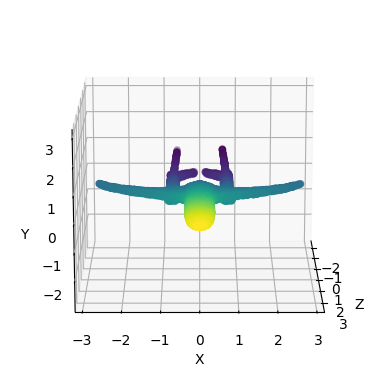

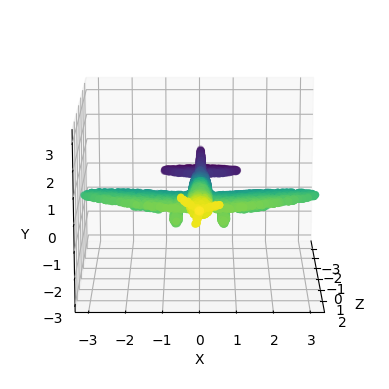

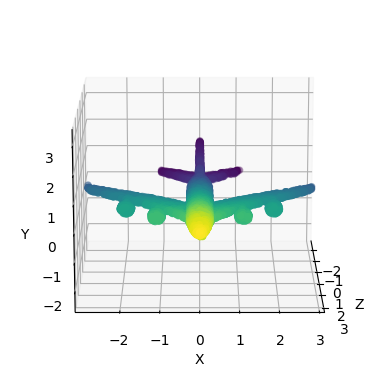

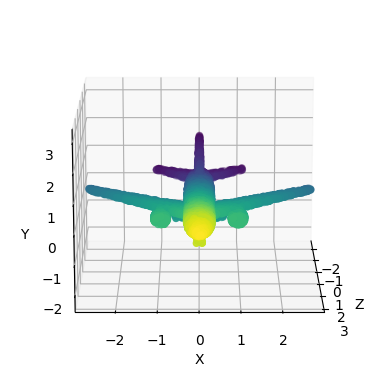

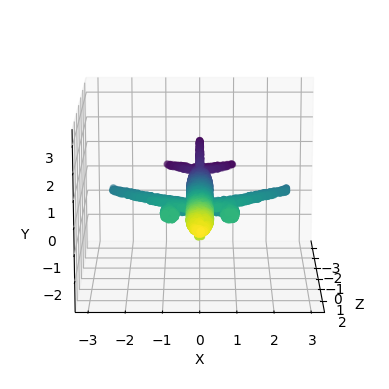

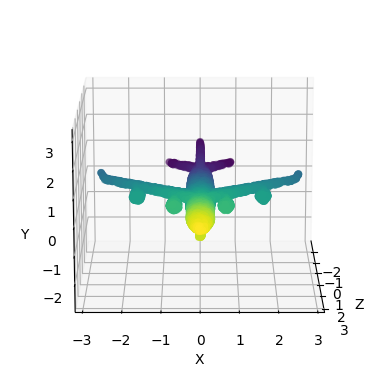

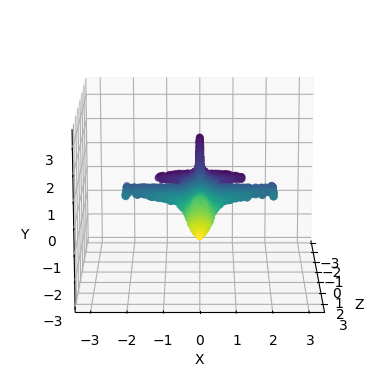

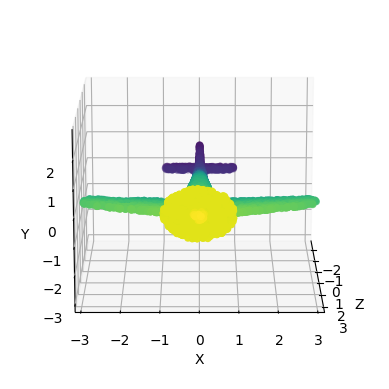

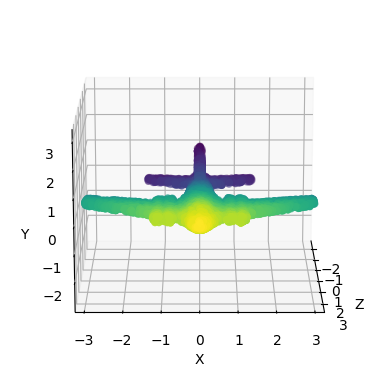

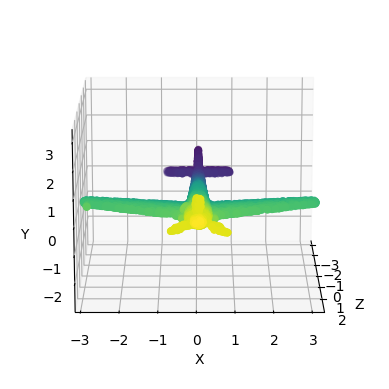

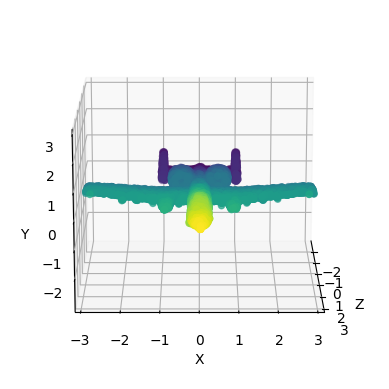

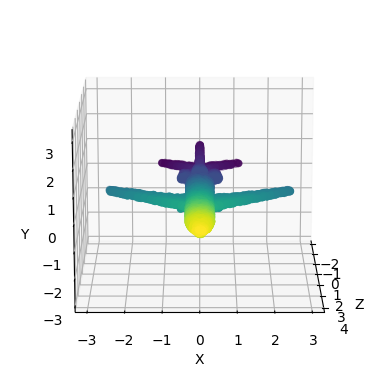

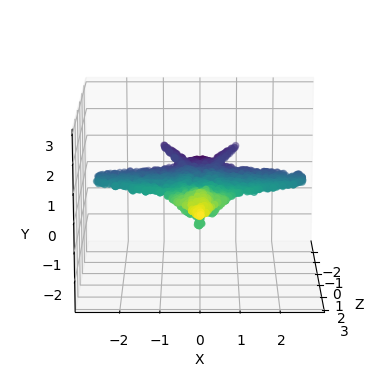

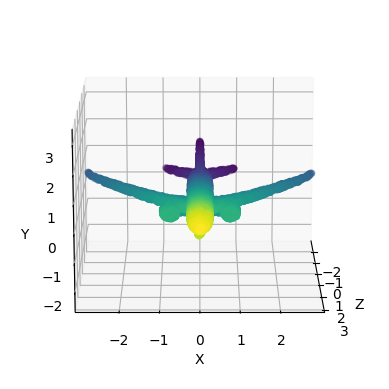

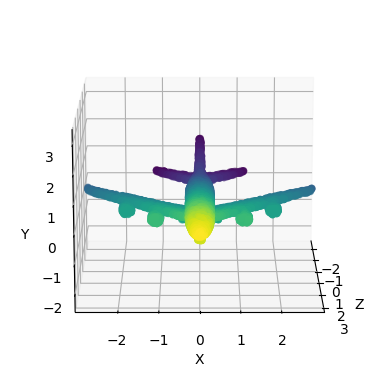

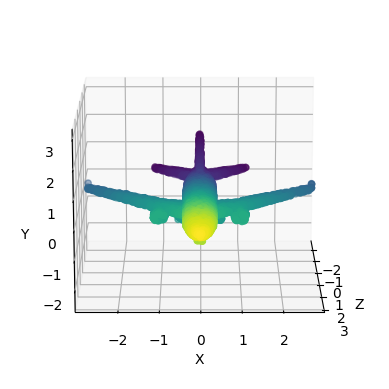

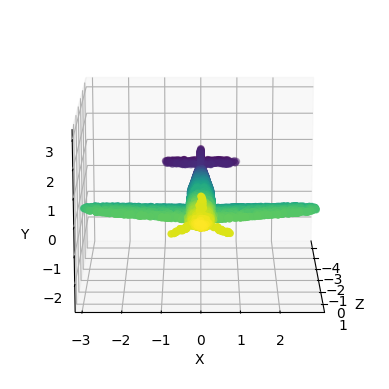

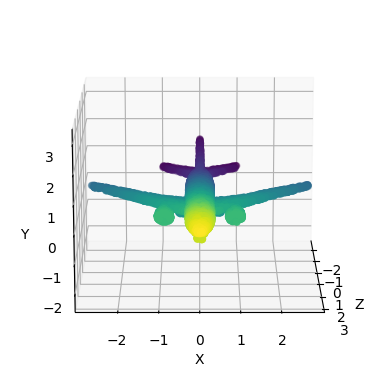

In [ ]:
for batch in itertools.islice(train_dataloader, 1):
  input = batch['train_points']
  for pc in input:
    visualize_pointcloud(pc)

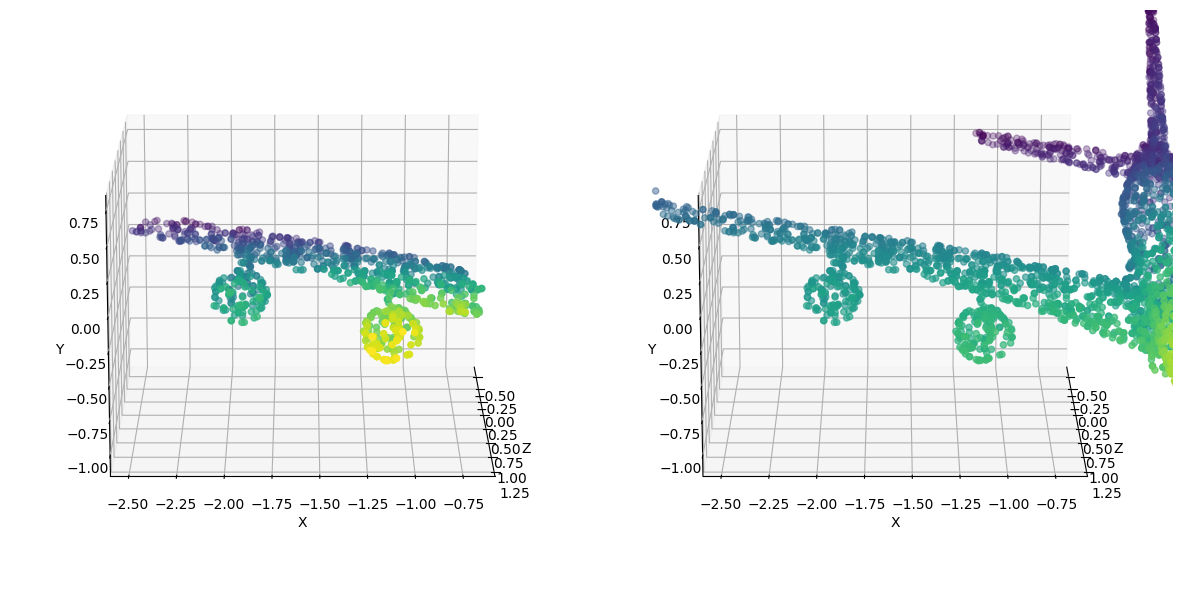

In [ ]:
#
INDEX = 8
input = next(iter(train_dataloader))["train_points"]

patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)
_ = visualize_pointcloud_eval(patched_input[INDEX], input[INDEX])

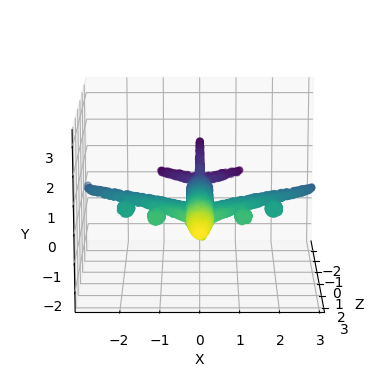

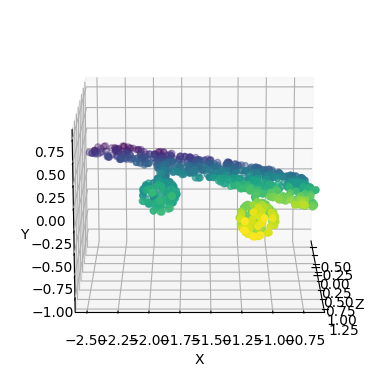

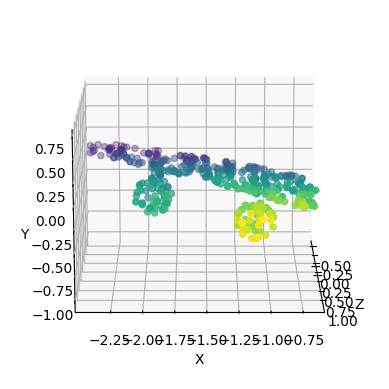

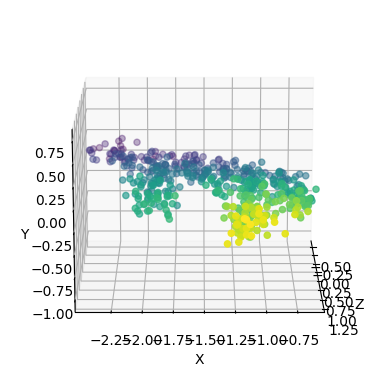

In [ ]:
# augmented_patch = remove_random_knn_points(patched_input, 20)

input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)

noised_downsampled_patches = add_random_noise(input_downsampled)

for pc in [input, patched_input, input_downsampled, noised_downsampled_patches]:
  visualize_pointcloud(pc[INDEX])

In [ ]:
index = torch.Tensor([INDEX])
from pathlib import Path

In [ ]:
pc_name = [(input, "input"), (patched_input, "patched_input"), (input_downsampled, "input_downsampled"), (noised_downsampled_patches, "nosed_downsampled_patches"), (index, "INDEX")]
path = Path("visuals/poster/training/")
path.mkdir(parents=True, exist_ok=True)
for pc, name in pc_name:
  torch.save(pc, path / f"{name}.pt")

In [ ]:
for pc, name in pc_name:
  pc = pc[INDEX].numpy()
  img = render_mitsuba(pc, str(path/ f"{name}.xml"), fov=20, n_points=pc.shape[0])
  plt.axis("off")
  plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
  plt.savefig(str(path / f"{name}.png"), bbox_inches='tight', pad_inches=0, dpi=400)

## Mitsuba

In [ ]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

In [ ]:
point_cloud = patched_input[INDEX].numpy()
point_cloud.shape

(1024, 3)

In [ ]:
plot_name = "test"
img = render_mitsuba(point_cloud, f"visuals/{plot_name}.xml", fov=20, n_points=1024)
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig(f"visuals/{plot_name}.png", bbox_inches='tight', pad_inches=0, dpi=400)

Center: [-0.03136194  0.39152342  1.7810352 ], Scale: 1.8537615537643433


2024-02-05 15:39:33 WARN main [integrator_v.cpp:32] Received interrupt signal, winding down..

KeyboardInterrupt: 

## Util

In [ ]:
def load_pts_to_tensor(filename):
    with open(filename, 'r') as file:
        points = []
        for line in file:
            x, y, z = map(float, line.strip().split())
            points.append([x, y, z])
        return torch.tensor(points, dtype=torch.float32)

In [ ]:
point_cloud = torch.load("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44/09-input.pth", map_location=torch.device('cpu'))

In [ ]:
img = render_mitsuba(point_cloud, "./test.xml", fov=20)

plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping~

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [ ]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44


In [ ]:
point_cloud = point_cloud.numpy().squeeze()

In [ ]:
point_cloud.shape

(2048, 3)

In [ ]:
base_dir = "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44"

In [ ]:
data = {i: {typ: torch.load(f"{base_dir}/{i:02d}-{typ}.pth", map_location=torch.device('cpu')).numpy().squeeze() for typ in ("input", "refined_output")} for i in range(10)}

In [ ]:
print(data)

In [ ]:
for index, results in data.items():
  for typ, point_cloud in results.items():
    plot_name = f"./pt-{index}-{typ}"
    img = render_mitsuba(point_cloud, f"{plot_name}.xml", fov=20)
    plt.axis("off")
    plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
    plt.savefig(f"{plot_name}.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
for i in range(10):
  img = render_mitsuba(point_cloud, "./test.xml", fov=20)

In [ ]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("test.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
plt.savefig(f"test.png", dpi=400)